<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/6b_multicollinearity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `bankdata` that contains the bank data from Makridakis Chapter 6.

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt  
#plt.style.use('dark_background')


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/bankdata.csv > bankdata.csv

bankdata = pd.read_csv('bankdata.csv', parse_dates=['date']).set_index('date').rename(columns={'34': 'mo_34'})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1687  100  1687    0     0   4820      0 --:--:-- --:--:-- --:--:--  4820


# Previous Analysis

As before, we'll execute the following steps:
* Create differenced versions of our data, 
* Compute correlations
* Fit a simple linear model

,balance,aaa,mo_34,d_balance,d_mo_34
date,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29
2000-03-01,358774,6.08,5.49,-2443.0,-0.11
2000-04-01,360271,6.17,5.80,1497.0,0.31
2000-05-01,360139,6.14,5.61,-132.0,-0.19
2000-06-01,362164,6.09,5.28,2025.0,-0.33


,balance,aaa,mo_34,d_balance,d_mo_34
balance,1.000000,0.330050,-0.265663,0.432892,0.043118
aaa,0.330050,1.000000,0.576137,0.197073,-0.077555
mo_34,-0.265663,0.576137,1.000000,-0.447305,0.173994
d_balance,0.432892,0.197073,-0.447305,1.000000,-0.171200
d_mo_34,0.043118,-0.077555,0.173994,-0.171200,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     19.12
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.28e-08
Time:                        22:09:22   Log-Likelihood:                -535.50
No. Observations:                  59   AIC:                             1079.
Df Residuals:                      55   BIC:                             1087.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4518.3745   3421.070     -1.321      0.192   -1.14e+04    2337.604
aaa         3476.3203    597.341      5.820      0.000    2279.221    4673.419
mo_34      -2937.4841    414.397     -7.089      0.000   -3767.954   -2107.014
d_mo_34      274.2125    898.104      0.305      0.761   -1525.628    2074.053
==============================================================================
Omnibus:                        0.049   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.976   Jarque-Bera (JB):                0.056
Skew:                          -0.043   Prob(JB):                        0.972
Kurtosis:                       2.875   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

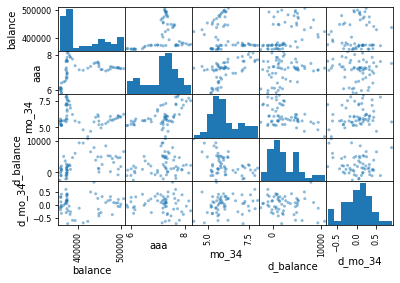

In [2]:
# Create difference variables
bankdata['d_balance'] = bankdata['balance'].diff()
bankdata['d_mo_34'] = bankdata['mo_34'].diff()
bankdata = bankdata.dropna()

# Peek at the data
display(bankdata.head())
# Plot scatter matrices
my_figure = pd.plotting.scatter_matrix(bankdata)
# Compute and display correlations
display(bankdata.corr())

# Fit a basic linear model
model = ols('d_balance ~ aaa + mo_34 + d_mo_34', bankdata)
results = model.fit()
display(results.summary())

# Checking for multicolinearity with the variance inflation factor

Recall that we can explore the presence of multicollinearity be calculating the variance inflation factor (VIF) for each of the linear model coefficients. We can import the `variance_inflation_factor` functions from `statsmodels.stats.outliers_influence` as follows:

```
from statsmodels.stats.outliers_influence import variance_inflation_factor
```

This function takes the full exogenous variable matrix as well as the index of the variable for which to calculate the VIF. Note that the VIF is not defined for the intercept, so we need to skip over the intercept in looping through our variables. 

The matrix of variables can be accessed from out model as follows:

```
variables = model.exog
```

We can then loop though the indexes that we want (in the case of the model above, we want to loop through the 1,2, and 3 indices (ignoring the 0th index, as that's for the intercept. 

In [3]:
variables = model.exog
for idx in [1, 2, 3]:
    print(variance_inflation_factor(variables, idx))

1.573645411273237
1.6130125421678292
1.0841206555673597


From the above, it appears that there is little to no multicollinearity between the variables in question. 

# Multicollinearity with Dummy Variables

We can now create dummy variables as before, and explore whether this creates multicollinearity in our variables. Recall that by default, the `pd.get_dummies()` function creates `S` dummy variables (for `S` seasonal periods) that are mutually exclusive and therefore explicitly linearly dependent. Let's first include all dummy variables in our analysis, and see what this does to the `VIF`. 

We'll start by creating the dummy variables and fitting a multiple linear regression on all variables:

In [4]:
# Create dummy variables
bankdata['month'] = bankdata.index.month
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month', drop_first=False)

# Add the dummy variables back into our original data
bankdata_months = bankdata.join(dummy_variables)
display(bankdata_months.head())

# Fit a linear regression to our data and print out the summary
model = ols('d_balance ~ aaa + mo_34 + d_mo_34 + month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', bankdata_months)
results = model.fit()
display(results.summary())

,balance,aaa,mo_34,d_balance,d_mo_34,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29,2,0,1,0,0,0,0,0,0,0,0,0,0
2000-03-01,358774,6.08,5.49,-2443.0,-0.11,3,0,0,1,0,0,0,0,0,0,0,0,0
2000-04-01,360271,6.17,5.80,1497.0,0.31,4,0,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,360139,6.14,5.61,-132.0,-0.19,5,0,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,362164,6.09,5.28,2025.0,-0.33,6,0,0,0,0,0,1,0,0,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     23.83
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           5.34e-16
Time:                        22:09:31   Log-Likelihood:                -493.16
No. Observations:                  59   AIC:                             1016.
Df Residuals:                      44   BIC:                             1047.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4172.3188   1738.794     -2.400      0.021   -7676.627    -668.011
aaa         3476.8752    328.727     10.577      0.000    2814.370    4139.380
mo_34      -2932.6483    230.462    -12.725      0.000   -3397.113   -2468.183
d_mo_34      423.4204    542.584      0.780      0.439    -670.086    1516.926
month_1     1657.2849    591.094      2.804      0.007     466.013    2848.556
month_2     1027.3251    527.412      1.948      0.058     -35.605    2090.255
month_3    -2971.8844    532.511     -5.581      0.000   -4045.090   -1898.679
month_4      358.2375    556.564      0.644      0.523    -763.444    1479.919
month_5    -1490.4118    546.233     -2.729      0.009   -2591.272    -389.551
month_6      354.6267    541.617      0.655      0.516    -736.931    1446.184
month_7     -531.4938    535.099     -0.993      0.326   -1609.915     546.927
month_8    -1934.8255    533.814     -3.625      0.001   -3010.657    -858.994
month_9    -3239.0544    535.154     -6.053      0.000   -4317.585   -2160.523
month_10      78.8003    538.734      0.146      0.884   -1006.946    1164.547
month_11    -949.4940    543.378     -1.747      0.088   -2044.601     145.613
month_12    3468.5707    535.563      6.476      0.000    2389.215    4547.926
==============================================================================
Omnibus:                        1.871   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.632
Skew:                          -0.403   Prob(JB):                        0.442
Kurtosis:                       2.887   Cond. No.                     8.95e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.6e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Now we can check the VIF of the above to probe for multicollinearity

In [5]:
variables = model.exog
variable_names = model.exog_names
for idx in range(1, variables.shape[1]):
    name = variable_names[idx]
    vif = variance_inflation_factor(variables, idx)
    print(name, vif)

aaa 1.6019250082025878
mo_34 1.676922962805247
d_mo_34 1.3300526338154992
month_1 inf
month_2 inf
month_3 inf
month_4 inf
month_5 inf
month_6 inf
month_7 inf
month_8 inf
month_9 inf
month_10 inf
month_11 inf
month_12 inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Notice that because we have _explicit linear dependence_ among a subset of the variables, the `VIF` for those variables is very large (infinite). Now let's repeat the creation of dummy variables, this time leaving out the first dummy variable:

In [6]:
# Create dummy variables
bankdata['month'] = bankdata.index.month
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month', drop_first=True)

# Add the dummy variables back into our original data
bankdata_months = bankdata.join(dummy_variables)
display(bankdata_months.head())

# Fit a linear regression to our data and print out the summary
model = ols('d_balance ~ aaa + mo_34 + d_mo_34 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', bankdata_months)
results = model.fit()
display(results.summary())

,balance,aaa,mo_34,d_balance,d_mo_34,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29,2,1,0,0,0,0,0,0,0,0,0,0
2000-03-01,358774,6.08,5.49,-2443.0,-0.11,3,0,1,0,0,0,0,0,0,0,0,0
2000-04-01,360271,6.17,5.80,1497.0,0.31,4,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,360139,6.14,5.61,-132.0,-0.19,5,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,362164,6.09,5.28,2025.0,-0.33,6,0,0,0,0,1,0,0,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     23.83
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           5.34e-16
Time:                        22:09:32   Log-Likelihood:                -493.16
No. Observations:                  59   AIC:                             1016.
Df Residuals:                      44   BIC:                             1047.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2515.0339   1963.446     -1.281      0.207   -6472.099    1442.032
aaa         3476.8752    328.727     10.577      0.000    2814.370    4139.380
mo_34      -2932.6483    230.462    -12.725      0.000   -3397.113   -2468.183
d_mo_34      423.4204    542.584      0.780      0.439    -670.086    1516.926
month_2     -629.9598    803.902     -0.784      0.437   -2250.117     990.198
month_3    -4629.1693    815.113     -5.679      0.000   -6271.921   -2986.417
month_4    -1299.0473    836.061     -1.554      0.127   -2984.017     385.922
month_5    -3147.6967    820.001     -3.839      0.000   -4800.299   -1495.094
month_6    -1302.6582    809.652     -1.609      0.115   -2934.404     329.088
month_7    -2188.7786    806.730     -2.713      0.009   -3814.637    -562.920
month_8    -3592.1103    805.333     -4.460      0.000   -5215.152   -1969.069
month_9    -4896.3393    802.936     -6.098      0.000   -6514.550   -3278.128
month_10   -1578.4846    802.059     -1.968      0.055   -3194.928      37.959
month_11   -2606.7789    818.726     -3.184      0.003   -4256.813    -956.744
month_12    1811.2858    810.983      2.233      0.031     176.858    3445.714
==============================================================================
Omnibus:                        1.871   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.632
Skew:                          -0.403   Prob(JB):                        0.442
Kurtosis:                       2.887   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
variables = model.exog
variable_names = model.exog_names
for idx in range(1, variables.shape[1]):
    name = variable_names[idx]
    vif = variance_inflation_factor(variables, idx)
    print(name, vif)

aaa 1.6019250082025878
mo_34 1.6769229628052464
d_mo_34 1.330052633815499
month_2 2.0692797796978324
month_3 2.1273971675200665
month_4 2.2381476421930206
month_5 2.1529873480829296
month_6 2.098987258775152
month_7 2.0838672759861248
month_8 2.076652431406762
month_9 2.0643102859540052
month_10 2.0598039731309767
month_11 2.146301145683505
month_12 2.1058929236360213


Note that we no longer have explicit linear dependence between the variables. The `VIF` for these variables is higher than for our non-dummy variables, but still much less than the standard cutoff of 5 for using the `VIF` to diagnose multicollinearity. 